In [1]:
import os
#os.environ["ASE_ABINIT_COMMAND"]="mpirun -np 8 abinit  < PREFIX.files > PREFIX.log"
os.environ["ABINIT_PP_PATH"]="/usr/share/abinit/psp:/usr/share/abinit/psp/HGH:/home/jochym/Projects/abinitio-methods/psp"

In [2]:
%pylab inline
import ase
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.calculators.abinit import Abinit
import ase.io
from ase import units as un
from ase.spacegroup import crystal

# Patch bug in ASE AbInit interface
import ase_patch
ase.io.abinit.read_abinit_out = ase_patch.read_abinit_out

from elastic import get_pressure, BMEOS, get_strain
from elastic import get_elementary_deformations, scan_volumes
from elastic import get_BM_EOS, get_elastic_tensor
from tqdm.auto import tqdm
from ipywidgets import interact
import nglview as nv

Populating the interactive namespace from numpy and matplotlib


In [3]:
def show_crystal(cryst):
    '''
    This function assumes cubic crystal on input. 
    If you want to use it for other structures you will need to adapt it.
    '''
    v = nv.NGLWidget()
    uc_a=1.5
    
    #cubic cell
    uc = ase.Atoms("C8", scaled_positions=[[0,0,0], 
                     [1,0,0],
                     [0,1,0],
                     [0,0,1],
                     [0,1,1],
                     [1,0,1],
                     [1,1,0],
                     [1,1,1],
                   ], cell=[uc_a,uc_a,uc_a])

    #cubic crystal
    a = cryst.cell.cellpar()[0]
    v.camera = 'orthographic'
    v.parameters = { "clipDist": 0 }

    o = v.add_structure(nv.ASEStructure(cryst))
    o.remove_ball_and_stick()
    o.add_spacefill(radius_scale=0.5, radiusType='covalent',
                            color_scheme='element', color_scale='rainbow')

    u = v.add_structure(nv.ASEStructure(uc))
    u.remove_spacefill()
    u.remove_ball_and_stick()
    u.add_line(cross_size=0.1)
    u.set_position(tuple((a-uc_a)*ones(3)/2))
    u.set_scale(a/uc_a)
    v.control.zoom(-1)
    v.control.spin([0,0,1], pi/2)
    v.control.center([a/2,a/2,a/2])
    return v, u, o, uc

In [4]:
def scan_param(cryst, param, start=0, stop=1, steps=7, 
               lista=None, log_scale=True, int_par=False):
    '''
    Scan a range of parameter param and plot 
    '''
    fi = lambda x: x
    fo = lambda x: x

    if lista is None:
        if log_scale :
            fi = log
            fo = exp
        lista = linspace(fi(start), fi(stop), steps)
    else :
        int_par=False
    
    dat = []
    vs = []
        
    for v in lista:
        print(f'{param}={fo(v)}: ', end='')
        if int_par:
            cryst.calc.set(**{param: int(fo(v))})
        else :
            cryst.calc.set(**{param: fo(v)})
        vs.append(fo(v))
        dat.append([cryst.get_potential_energy(),
                    cryst.get_stress()[:3].mean()])
        print(f'{dat[-1][0]:.3f} eV ; {dat[-1][1]/un.GPa:6.3f} GPa',)
    dat = array(dat).T
    return vs, dat

In [5]:
a = 4.194
cryst = crystal(['Mg', 'O'], 
                [(0, 0, 0), (0.5, 0.5, 0.5)], 
                spacegroup=225,
                cellpar=[a, a, a, 90, 90, 90])

In [6]:
v, ucv, crv, uc = show_crystal(cryst)
v

NGLWidget()

In [7]:
@interact
def rot(a=(0.5,1.5,0.01), b=(-1,1,0.01)):
    m = array([[a,b,0],
               [0,1,0],
               [0,0,1]])
    cr = ase.Atoms(uc)
    cr.set_cell(dot(m, uc.cell.array), scale_atoms=True)
    ucv.set_coordinates(cr.get_positions())
    cr = ase.Atoms(cryst)
    cr.set_cell(dot(m, cryst.cell.array), scale_atoms=True)
    crv.set_coordinates(cr.get_positions())

interactive(children=(FloatSlider(value=1.0, description='a', max=1.5, min=0.5, step=0.01), FloatSlider(value=…

In [8]:
Scan_Corvengence = False

In [9]:
def create_calculator(label, directory='work_07', ecut=450):
    return Abinit(label=label, directory=directory, v8_legacy_format=True,
              ecut= ecut,
              pps = 'pawxml', pawecutdg = 750, xc = 'GGA',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[2,2,2],
              nshiftk=1,
              shiftk=[[0.5, 0.5, 0.5]],
              )

In [10]:
calc = create_calculator(label='MgO')
cryst.set_calculator(calc)
print(cryst.get_potential_energy(), cryst.get_stress()/un.GPa)

-8690.547905966881 [-1.3641686 -1.3641686 -1.3641686  0.         0.         0.       ]


In [11]:
if Scan_Corvengence :
    ecuts, eres = scan_param(cryst, 'ecut', 400, 700, 4)

    figsize(6,6)
    subplot(211)
    plot(ecuts, eres[0], 'o')
    ylabel('Energy (eV)')
    subplot(212)
    plot(ecuts, eres[1]/un.GPa, 'o')
    ylabel('Pressure (GPa)')
    xlabel('ecut (eV)');

In [12]:
print(f'Residual pressure: {get_pressure(cryst.get_stress())/un.GPa:.3f} GPa')

Residual pressure: 1.364 GPa


### Birch-Murnaghan Equation of State

---

Let us now use the tools provided by the modules to calculate equation
of state for the crystal and verify it by plotting the data points
against fitted EOS curve. The EOS used by the module is a well
established Birch-Murnaghan formula (P - pressure, V - volume, B
-parameters):

$$P(V)= \frac{B_0}{B'_0}\left[
\left({\frac{V}{V_0}}\right)^{-B'_0} - 1
\right]$$

---

In [13]:
# Calculate few volumes and fit B-M EOS to the result
# Use +/-3% volume deformation and 5 data points
deform=scan_volumes(cryst, n=5,lo=0.97,hi=1.03)

print('Calculating: ', end='')
for n, s in enumerate(tqdm(deform)):
    s.set_calculator(create_calculator(f'MgO_deform_{n}'))
    s.get_stress()

print('done.')

Calculating: 

  0%|          | 0/5 [00:00<?, ?it/s]

done.


V0=74.366 A^3 ; B0=169.54 GPa ; B0'=3.660 ; a0=4.20525 A


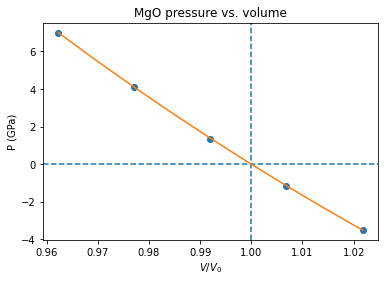

In [14]:
# Post-process the results
fit=get_BM_EOS(cryst, systems=deform)

# Print just fitted parameters
print("V0=%.3f A^3 ; B0=%.2f GPa ; B0'=%.3f ; a0=%.5f A" % ( 
        fit[0], fit[1]/un.GPa, fit[2], pow(fit[0],1./3)))

v0=fit[0]

# Get the P(V) data points just calculated
pv = array([[s.get_volume(), get_pressure(s.get_stress())] for s in deform])

# Sort data on the first column (V)
pv=pv[pv[:, 0].argsort()]

# B-M EOS for plotting
fitfunc = lambda p, x: numpy.array([BMEOS(xv,p[0],p[1],p[2]) for xv in x])

# Ranges - the ordering in pv is not guarateed at all!
# In fact it may be purely random.
x=numpy.array([min(pv[:,0]),max(pv[:,0])])
y=numpy.array([min(pv[:,1]),max(pv[:,1])])

# Plot the P(V) curves and points for the crystal
# Plot the points
plt.plot(pv[:,0]/v0,pv[:,1]/un.GPa,'o')

# Mark the center P=0 V=V0
plt.axvline(1,ls='--')
plt.axhline(0,ls='--')

# Plot the fitted B-M EOS through the points
xa=numpy.linspace(x[0],x[-1],20)
plt.plot(xa/v0,fitfunc(fit,xa)/un.GPa,'-')
plt.title('MgO pressure vs. volume')
plt.xlabel('$V/V_0$')
plt.ylabel('P (GPa)')
plt.show()

$$
V_0 = 73.75 \text{ A}^3 \quad
B_0 = 170 \text{ GPa}  \quad
B'_0 = 4.3  \quad
a_0 = 4.1936 \text{ A}
$$

### Automatic calculation of elastic tensor

---

First we calculate elastic constants of MgO with internal routine of the Elastic library by generating set of deformed cells and solving the resulting linear equation.

In [ ]:
# Create elementary deformations
cij_deform = get_elementary_deformations(cryst, n=5, d=0.33)

# Run the stress calculations on deformed cells

print('Calculating: ', end='')
for n, s in enumerate(tqdm(cij_deform)):
    s.set_calculator(create_calculator(f'MgO_cij_{n}'))
    s.get_stress()

print('done.')

Calculating: 

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Elastic tensor by internal routine
Cij, Bij = get_elastic_tensor(cryst, systems=cij_deform)
print("Cij (11, 12, 44): %.2f, %.2f, %.2f GPa" % tuple(Cij/un.GPa))

### Manual calculation of elastic tensor

---

To make sure we are getting the correct answer let us make the
calculation for $C_{11}, C_{12}$ by hand. We will deform the cell along
a (x) axis by +/-0.2% and fit the $3^{rd}$ order polynomial to the
stress-strain data. The linear component of the fit is the element of
the elastic tensor:

In [ ]:
from elastic.elastic import get_cart_deformed_cell

# Create deformation points on the a axis
cij_sys = [get_cart_deformed_cell(cryst, axis=0, size=d) 
               for d in numpy.linspace(-0.2,0.2,6)]

# Calculate the systems and collect the stress tensor for each system
print('Calculating: ', end='')
for n, s in enumerate(tqdm(cij_sys)):
    s.set_calculator(create_calculator(f'MgO_cij_man_{n}'))
    s.get_stress()
print('done.')

In [ ]:
ss=[[get_strain(s, cryst), s.get_stress()] for s in cij_sys]


ss=numpy.array(ss)
lo=min(ss[:,0,0])
hi=max(ss[:,0,0])
mi=(lo+hi)/2
wi=(hi-lo)/2
xa=numpy.linspace(mi-1.1*wi,mi+1.1*wi, 50)

# Make a plot
plt.plot(ss[:,0,0],ss[:,1,0]/un.GPa,'.')
plt.plot(ss[:,0,0],ss[:,1,1]/un.GPa,'.')

plt.axvline(0,ls='--')
plt.axhline(0,ls='--')

# Now fit the polynomials to the data to get elastic constants
# C11 component
f=numpy.polyfit(ss[:,0,0],ss[:,1,0],3)
c11=f[-2]/un.GPa

# Plot the fitted function
plt.plot(xa,numpy.polyval(f,xa)/un.GPa,'-', label='$C_{11}$')

# C12 component
f=numpy.polyfit(ss[:,0,0],ss[:,1,1],3)
c12=f[-2]/un.GPa

# Plot the fitted function
plt.plot(xa,numpy.polyval(f,xa)/un.GPa,'-', label='$C_{12}$')
plt.xlabel('Relative strain')
plt.ylabel('Stress componnent (GPa)')
plt.title('MgO, strain-stress relation ($C_{11}, C_{12}$)')
plt.legend(loc='best')

# Here are the results. They should agree with the results
# of the internal routine.
print('C11 = %.3f GPa, C12 = %.3f GPa => K= %.3f GPa' % (
        c11, c12, (c11+2*c12)/3))

plt.show()

If you set up everything correctly you should obtain fitted parameters
printed out in the output close to:

    C11 = 325 GPa, C12 = 100 GPa => K= 180 GPa

The actual numbers depend on the details of the calculations setup but
should be fairly close to the above results.